In [1]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29413 sha256=f5e5454dfe3bde28da9175f3a9c6f44ee6d9eee995ad28a04011bf1c49422708
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import ta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, InputLayer, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

In [51]:
df = pd.read_csv("/kaggle/input/stock-dataset/JPM_target.csv")
df

,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume,avg_pred_10,avg_pred_30
0,0,1980-03-17,0.000000,5.129630,5.018519,5.037037,1.077434,62775,0.014338,0.046936
1,1,1980-03-18,0.000000,5.111111,5.037037,5.074074,1.085356,64125,0.007664,0.041484
2,2,1980-03-19,0.000000,5.166667,5.111111,5.148148,1.101201,40500,-0.003957,0.028777
3,3,1980-03-20,0.000000,5.148148,5.092593,5.111111,1.093279,18900,0.010870,0.039130
4,4,1980-03-21,0.000000,5.222222,5.111111,5.222222,1.117046,97200,-0.004610,0.021040
...,...,...,...,...,...,...,...,...,...,...
11151,11151,2024-06-10,199.240005,200.839996,198.440002,199.610001,199.610001,6071200,NaN,NaN
11152,11152,2024-06-11,197.910004,197.940002,193.600006,194.360001,194.360001,9235300,NaN,NaN
11153,11153,2024-06-12,196.000000,196.720001,191.309998,191.529999,191.529999,12751300,NaN,NaN
11154,11154,2024-06-13,192.320007,194.580002,190.880005,193.660004,193.660004,8587800,NaN,NaN


In [52]:
def calc_indicators(df):
    ## macd
    data = ta.trend.MACD(df["Close"], 12, 26, 9)
    df["macd"] = data.macd()
    df["macd_signal"] = data.macd_signal()
    
    ## rsi
    data = ta.momentum.RSIIndicator(df["Close"], 14)
    df["rsi"] = data.rsi()
    
    ## obv
    data = ta.volume.OnBalanceVolumeIndicator(df["Close"], df["Volume"])
    df["obv"] = data.on_balance_volume()
    
    ## ema
    data = ta.trend.ema_indicator(df["Close"], 12)
    df["ema_12"] = data
    
    ## remove redundancy
    df = df.drop(["Date", "Open", "High", "Low", "Volume","Adj Close", "Unnamed: 0", "avg_pred_30"], axis=1)
    df = df.dropna()
    
    df = df[["Close", "macd", "macd_signal", "rsi", "obv", "ema_12"]]
    
    # normalize
    df=(df-df.min())/(df.max()-df.min())
    
    return df
    
df = calc_indicators(df)
df

,Close,macd,macd_signal,rsi,obv,ema_12
33,0.010826,0.307745,0.303615,0.676343,0.562402,0.008849
34,0.012297,0.305953,0.303020,0.799815,0.562632,0.009214
35,0.011838,0.305015,0.302328,0.724402,0.562579,0.009450
36,0.012297,0.303942,0.301530,0.758752,0.562758,0.009723
37,0.012205,0.303265,0.300735,0.743551,0.562744,0.009939
...,...,...,...,...,...,...
11141,0.979743,0.192501,0.167849,0.605508,0.372292,0.996019
11142,0.973736,0.197026,0.169442,0.573778,0.369736,0.996781
11143,0.966835,0.207979,0.173227,0.537951,0.367473,0.996334
11144,0.972892,0.212375,0.177262,0.565459,0.369999,0.996914


In [53]:
data = np.array(df)
data.shape

(11113, 6)

In [54]:
train_ratio=0.8
val_ratio=0.1

train_data = data[:int(train_ratio*len(data))]
val_data = data[int(train_ratio*(len(data))):int((train_ratio+val_ratio)*len(data))]
test_data = data[int((train_ratio + val_ratio)*len(data)):]

print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(8890, 6)
(1111, 6)
(1112, 6)


In [55]:
def createXy(data, period=10, frame=10):
    Xs=[]
    ys=[]
    for i in range(period, len(data)-frame):
        Xs.append(data[i-period:i])
        ys.append(data[i+frame, 0])
    return np.array(Xs), np.array(ys)

X_train, y_train = createXy(train_data, 100)
X_val, y_val = createXy(val_data, 100)
X_test, y_test = createXy(test_data, 100)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(8780, 100, 6) (8780,)
(1001, 100, 6) (1001,)
(1002, 100, 6) (1002,)


# create Model

In [56]:
model=Sequential()
model.add(InputLayer(shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(200,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(200,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(200))
model.add(Dropout(0.2))
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 100, 200)       │       165,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 100, 200)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 100, 200)       │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 100, 200)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 200)            │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 832,871 (3.18 MB)

 Trainable params: 832,871 (3.18 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001))
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, verbose=1)

Epoch 1/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.0088 - val_loss: 0.0019
Epoch 2/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 2.7080e-04 - val_loss: 0.0021
Epoch 3/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 2.5709e-04 - val_loss: 0.0030
Epoch 4/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 2.1542e-04 - val_loss: 0.0019
Epoch 5/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 2.0128e-04 - val_loss: 0.0021
Epoch 6/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 1.8417e-04 - val_loss: 0.0045
Epoch 7/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 1.9737e-04 - val_loss: 6.0214e-04
Epoch 8/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 2.0052e-04 - val_loss: 0.0018
Epoch 9/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 2.1082e-04 - val_loss: 8.8578e-04
Epoch 10/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 1.8197e-04 - val_loss: 0.0018
Epoch 11/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 1.8049e-04 - val_loss:

In [ ]:
pred = model.predict(X_test)
pred.shape

[]

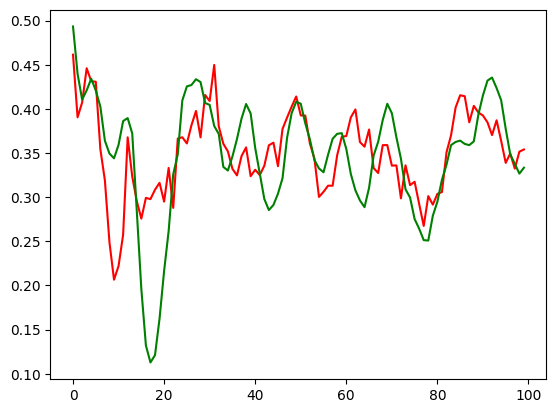

In [41]:
plt.plot(y_test[:100], color="r")
plt.plot(pred[0:100], color="g")
plt.plot()